<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Stuff" data-toc-modified-id="Import-Stuff-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Stuff</a></span></li><li><span><a href="#Load-Appropriate-Dataframes" data-toc-modified-id="Load-Appropriate-Dataframes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Appropriate Dataframes</a></span></li><li><span><a href="#Function" data-toc-modified-id="Function-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Function</a></span><ul class="toc-item"><li><span><a href="#Anonymous" data-toc-modified-id="Anonymous-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Anonymous</a></span></li><li><span><a href="#Named" data-toc-modified-id="Named-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Named</a></span></li></ul></li><li><span><a href="#Differences" data-toc-modified-id="Differences-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Differences</a></span><ul class="toc-item"><li><span><a href="#Vacuum-----Beryl" data-toc-modified-id="Vacuum-----Beryl-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Vacuum --- Beryl</a></span></li><li><span><a href="#Beryl-----Vacuum_Beryl" data-toc-modified-id="Beryl-----Vacuum_Beryl-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Beryl --- Vacuum_Beryl</a></span></li><li><span><a href="#Vacuum-----Vacuum_Beryl" data-toc-modified-id="Vacuum-----Vacuum_Beryl-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Vacuum --- Vacuum_Beryl</a></span></li><li><span><a href="#Fit-Avg.-Scaled-Potential-Map" data-toc-modified-id="Fit-Avg.-Scaled-Potential-Map-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Fit Avg. Scaled Potential Map</a></span></li></ul></li></ul></div>

# Import Stuff

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
pd.options.mode.chained_assignment = None # Suppresses annoying warning
#sns.set()
sns.set(font_scale=1.5)
#sns.set_context("poster")

# Load Appropriate Dataframes

In [2]:
with open('tidy_data/df_fine_sweep.pkl','rb') as fin:
    df_fine_sweep = pkl.load(fin)
with open('tidy_data/df_vacuum_beryl.pkl','rb') as fin:
    df_vacuum_beryl = pkl.load(fin)
with open('tidy_data/df_vacuum.pkl','rb') as fin:
    df_vacuum = pkl.load(fin)
    df_vacuum = df_vacuum[df_vacuum.coupling == 'antiferro'] # only want antiferro here
    
df_vacuum.head()

,config,coupling,energy,fill
0,0,antiferro,-14.224739,1000
1,1,antiferro,-14.224739,1000
2,10,antiferro,-14.224742,1000
3,11,antiferro,-14.224749,1000
4,12,antiferro,-14.224757,1000


# Function

## Anonymous

In [3]:
filter_by_fill = lambda fill, df: df[df.fill == fill].sort_values("config")
filter_by_coupling = lambda couple, df: df[df.coupling == couple]
get_energy_differences = lambda df1, df2: df1.energy.values-df2.energy.values

## Named

In [23]:
def zero_energy(df,couple="antiferro"):
    #df = filter_by_couple(couple,filter_by_fill(fill))
    #df.sort_values("config",axis=0,inplace=True)
    zero_en = df.energy.values[0]
    df.energy -= zero_en
    scale = len(df.config)-1
    df.config *= 0.01
    
    return df

def take_difference(df1,df2,fill):
    df1_fill = zero_energy(filter_by_fill(fill,df1))
    df2_fill = zero_energy(filter_by_fill(fill,df2))
    
    df_diff = df1_fill.copy()
    df_diff['energy'] = get_energy_differences(df1_fill,df2_fill)*10**3
    
    return df_diff

def plot_differences(df1,df2,scaled=False,double=False,ax=None,vacuum=False):
    if not double:
        fig = plt.figure(figsize=(12,8))
        ax = plt.gca()
    fills = list(set(df1.fill.values))
    scales = [1.,2.,2.,3.,4.]
    for fill,scale in zip(fills,scales):
        df = take_difference(df1,df2,fill)
        if scaled:
            df.energy *= 1./scale
            if not vacuum:
                sns.lineplot(x='config',y='energy',ax=ax,
                             data=df,label='Fill {}'.format(fill))
            else:
                data = df
                ax.plot(data.config.values,data.energy.values,color='black',linestyle=':')
        else:
            if not vacuum:
                sns.lineplot(x='config',y='energy',ax=ax,
                             data=df,label='Fill {}'.format(fill))
            else:
                data = df
                ax.plot(data.config.values,data.energy.values,color='black',linestyle=':')
    ax.set(xlabel='Rotation Angle [rad]',ylabel='Energy Difference (Beryl$-$Vaccum) [meV]')
    
    
    

# Differences

## Vacuum --- Beryl

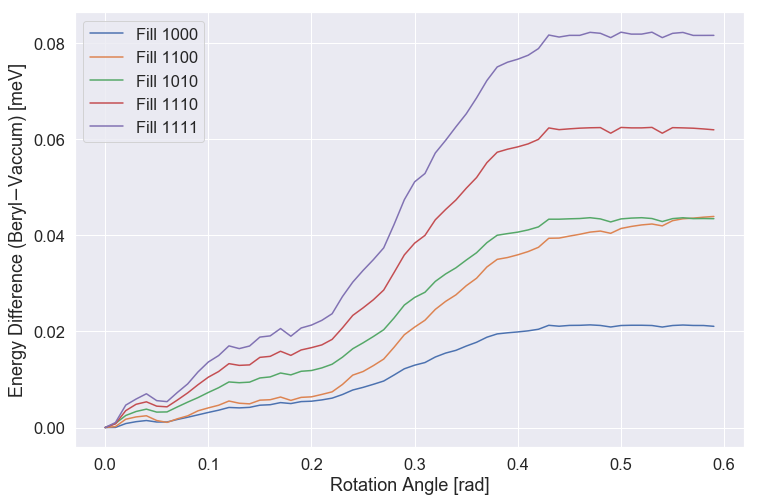

In [27]:
fig = plt.figure(figsize=(12,8))
ax = plt.gca()
plot_differences(df_fine_sweep,df_vacuum_beryl,double=True,ax=ax)
#plot_differences(df_fine_sweep,df_vacuum,double=True,ax=ax,vacuum=True)

## Beryl --- Vacuum_Beryl

This map represents the crystal contribution to the total potential map

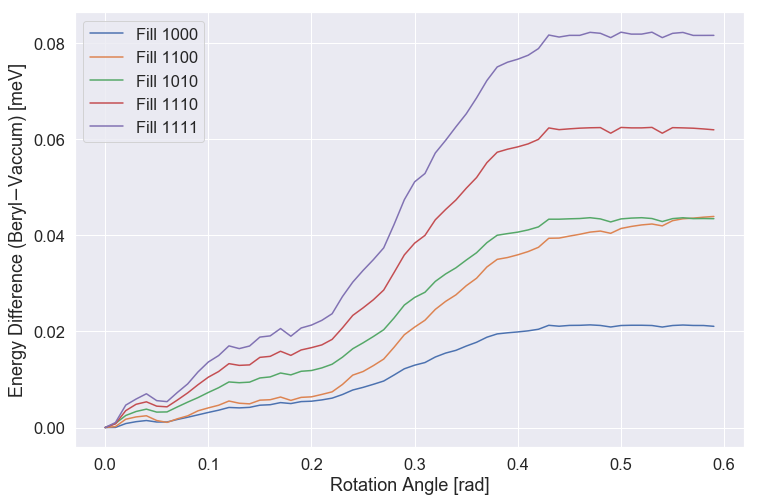

In [6]:
plot_differences(df_fine_sweep,df_vacuum_beryl)

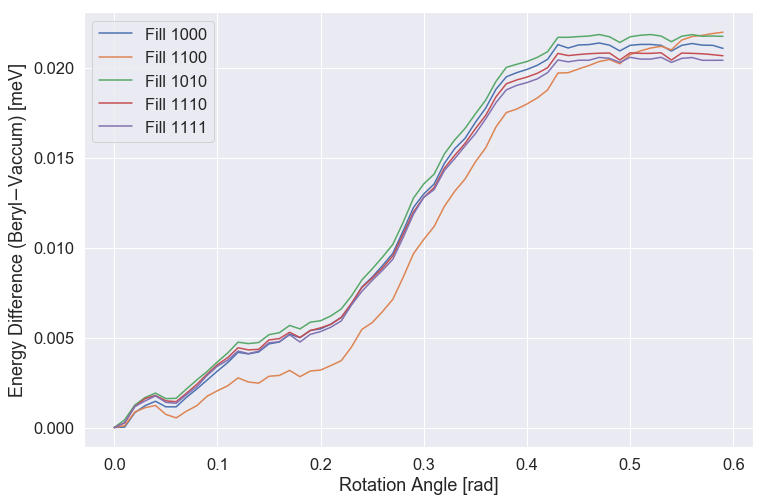

In [7]:
plot_differences(df_fine_sweep,df_vacuum_beryl,scaled=True)

## Vacuum --- Vacuum_Beryl

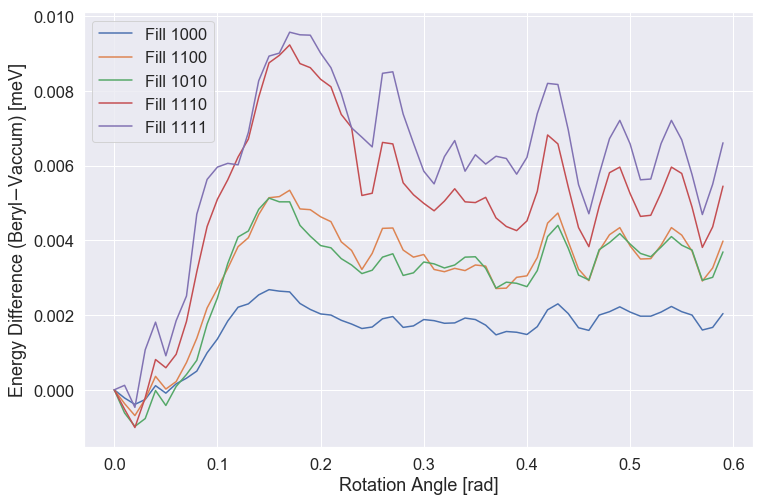

In [26]:
plot_differences(df_vacuum_beryl,df_vacuum)

## Fit Avg. Scaled Potential Map

In [9]:
df1 = df_fine_sweep
df2 = df_vacuum_beryl

fills = list(set(df1.fill.values))
scales = [1.,2.,2.,3.,4.]
dfs = []
for fill,scale in zip(fills,scales):
    df = take_difference(df1,df2,fill)
    df.energy *= 1./scale
    df.drop(['coupling','fill'],axis=1,inplace=True)
    dfs.append(df)
    
for i,df in enumerate(dfs):
    if i == 0:
        final_df = df.copy()
    else:
        final_df = pd.concat([final_df,df])






In [14]:

def func(x,A,w,n):
    return A*np.sin(np.pi/2*(np.sin(w*x)))**(n)

def func2(x,A,n):
    return A*np.sin(np.pi/2*(3*n-n**3)/(2))

def func3(x,A,n,w):
    return A*np.sqrt((1+n**2)/(1+(n*np.cos(w*x))**2))*np.cos(w*x)

def plot_scaled_fit(func):
    df_avg_scaled_energy = final_df.groupby('config').mean()
    df_avg_scaled_energy['sems'] = final_df.groupby('config').sem()
    fig = plt.figure(figsize=(12,8))
    ax = plt.gca()
    ax.set(xlabel='Rotation Angle [rad]',ylabel='Avg. Scaled Energy Difference \n(Beryl$-$Vaccum) [meV]')
    data=df_avg_scaled_energy.reset_index()
    ax.errorbar(data.config.values,data.energy.values,yerr=data.sems.values)#,linestyle=':')



    x = np.linspace(0.,0.6,60)
    popt, pcov = curve_fit(func, x, df.energy.values)
    try:
        A, w,n = popt
        y = [func(i,A,w,n) for i in x]
    except:
        A, n = popt
        y = [func(i,A,n) for i in x]
    ax.plot(x,y)
    return A,w,n

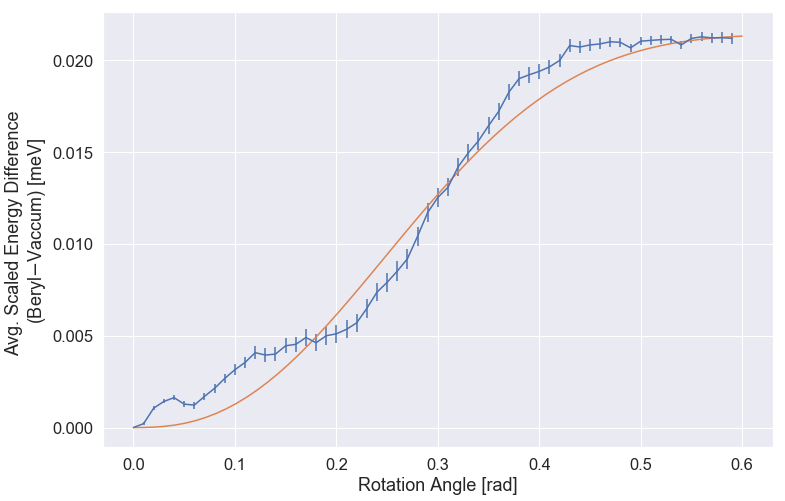

In [15]:
A,w,n = plot_scaled_fit(func);


In [30]:
print('{:.4f},{:.4f},{:.4f}'.format(A,w,n))

0.0214,2.1772,2.5685


In [13]:
popt

NameError: name 'popt' is not defined